# Tagup data science challenge

ExampleCo, Inc has a problem: maintenance on their widgets is expensive. They have contracted with Tagup to help them implement predictive maintenance. They want us to provide a model that will allow them to prioritize maintenance for those units most likely to fail, and in particular to gain some warning---even just a few hours!---before a unit does fail.

They collect two kinds of data for each unit. First, they have a remote monitoring system for the motors in each unit, which collects information about the motor (rotation speed, voltage, current) as well as two temperature probes (one on the motor and one at the inlet). Unfortunately, this system is antiquated and prone to communication errors, which manifest as nonsense measurements. Second, they have a rule-based alarming system, which can emit either warnings or errors; the system is known to be noisy, but it's the best they've got. 

They have given us just over 100MB of historical remote monitoring data from twenty of their units that failed in the field. The shortest-lived units failed after a few days; the longest-lived units failed after several years. Typical lifetimes are on the order of a year. This data is available in .csv files under `data/train` in this repository. In addition, they have provided us with operating data from their thirty active units for the past month; this data is available under `data/test` in this repository.

You have two main objectives. First, **tell us as much as you can about the process that generated the data**. Does it show meaningful clustering? Do the observations appear independent? How accurately can we forecast future observations, and how long a window do we need to make an accurate forecast? Feel free to propose multiple models, but be sure to discuss the ways each is useful and the ways each is not useful. Second, **predict which of the thirty active units are most likely to fail**. The data from these units are in `data/test`. Be sure to quantify these predictions, and especially your certainty.

A few notes to help:
1. A good place to start is by addressing the noise due to comm errors. 
2. There is a signal in the data that you can identify and exploit to predict failure.
3. If you can't find the signal in the noise, don't despair! We're much more interested in what you try and how you try it than in how successful you are at helping a fictional company with their fictional problems.
4. Feel free to use any libraries you like, or even other programming languages. Your final results should be presented in this notebook, however.
5. There are no constraints on the models or algorithms you can bring to bear. Some ideas include: unsupervised clustering algorithms such as k-means; hidden Markov models; forecasting models like ARMA; neural networks; survival models built using features extracted from the data; etc.
6. Don't feel compelled to use all the data if you're not sure how. Feel free to focus on data from a single unit if that makes it easier to get started.
7. Be sure to clearly articulate what you did, why you did it, and how the results should be interpreted. In particular you should be aware of the limitations of whatever approach or approaches you take.
8. Don't hesitate to reach out with any questions.

,rpm,motor_voltage,motor_current,motor_temp,inlet_temp
count,9.171500e+04,9.171500e+04,9.171500e+04,9.171500e+04,9.171500e+04
mean,-8.111152e+46,-4.431337e+60,-1.387827e+56,-6.640742e+69,-1.937422e+48
std,2.456380e+49,1.903274e+63,4.202968e+58,2.011115e+72,5.867349e+50
min,-7.439020e+51,-5.565298e+65,-1.272847e+61,-6.090557e+74,-1.776896e+53
25%,1.017725e+03,2.311319e+02,3.239347e+01,1.179731e+02,6.489677e+01
50%,1.066347e+03,2.667104e+02,3.944687e+01,1.564521e+02,7.799157e+01
75%,1.106721e+03,2.993994e+02,4.607173e+01,1.978223e+02,9.086132e+01
max,7.978110e+44,1.500194e+65,1.555360e+55,3.117856e+55,1.710299e+40


,message
count,305
unique,2
top,warning
freq,304


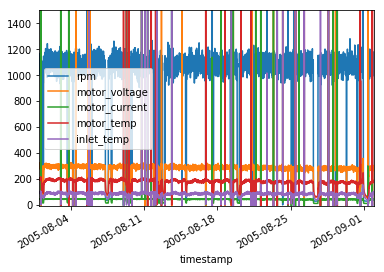

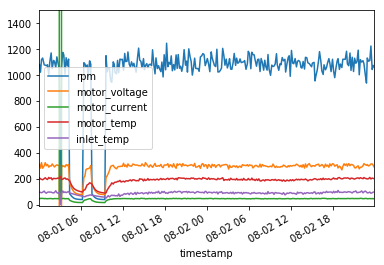

In [1]:
# To help you get started...
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline 

def load_rms(filename):
    return pd.read_csv(filename, index_col="timestamp", parse_dates=True)
def load_alarms(filename):
    return pd.read_csv(filename, header=None, names=["timestamp", "message"], index_col="timestamp", parse_dates=True)

rms = load_rms('data/train/unit0000_rms.csv')
alarms = load_alarms('data/train/unit0000_alarms.csv')
rms.loc["2005-08-01":"2005-09-01"].plot(ylim=(-10, 1500))
rms.loc["2005-08-01":"2005-08-02"].plot(ylim=(-10, 1500))

display(rms.describe())
display(alarms.describe())

I removed the .describe" in `load_alarms` and started to explore the data:

In [2]:
rms.head()

,rpm,motor_voltage,motor_current,motor_temp,inlet_temp
timestamp,,,,,
2003-12-13 19:56:43.777979848,0.150438,-0.059544,0.045503,5.084823,0.019528
2003-12-13 20:07:32.457298714,0.511660,0.627101,0.208669,7.334172,2.081454
2003-12-13 20:13:43.182783330,0.824233,1.732618,0.286401,8.843053,3.485346
2003-12-13 20:27:19.295198297,1.506626,3.115258,0.483992,11.749493,6.041188
2003-12-13 20:35:08.719032171,2.034869,3.923323,0.851620,12.947061,7.309662


Any nans ?

In [3]:
rms[rms.isnull().any(axis=1)]

,rpm,motor_voltage,motor_current,motor_temp,inlet_temp
timestamp,,,,,


No, good!

The min/max/quantile values in the rms data seem to hint at noise showing up as negative and extreme positive values, which don't look like physically reasonable measurements.


How do median and 1 / 99 percentiles change after removing all negative values:



In [4]:
# Before:
display(rms.quantile([0.01,0.5,0.99]))

,rpm,motor_voltage,motor_current,motor_temp,inlet_temp
0.01,-14.193940,-28.023725,-6.443479,29.201543,23.244034
0.50,1066.347072,266.710408,39.446872,156.452066,77.991573
0.99,1219.681503,333.609836,50.751851,288.430906,202.223517


Find rows with negative values:

In [5]:
negativeRows = rms[(rms[[col for col in rms.columns]]<0).any(axis=1)]
print("Rows with negative measurements: %d, i.e. %.2f %%"%(negativeRows.shape[0], (100.*negativeRows.shape[0])/rms.shape[0]))

Rows with negative measurements: 1831, i.e. 2.00 %


Remove these rows...

In [6]:
rms_pos = rms.drop(negativeRows.index)

In [7]:
# After:
display(rms_pos.quantile([0.01,0.5,0.99]))

,rpm,motor_voltage,motor_current,motor_temp,inlet_temp
0.01,6.756457,13.559209,2.719192,43.175688,32.641437
0.50,1067.332826,267.746495,39.642989,157.581311,78.215427
0.99,1205.652051,330.628904,50.384828,241.945295,165.009159


Median values stayed stable, removing 2% of rows of course has some effect on the outer quantiles.

Cutting out the most extreme values which are most likely noise, since they look totally unrealistic:

In [8]:
too_large = rms_pos[(rms_pos[[col for col in rms_pos.columns]]>1e6).any(axis=1)].index

In [9]:
rms_clean = rms_pos.drop(too_large)

A look to check sanity of cleaned data for this one unit:

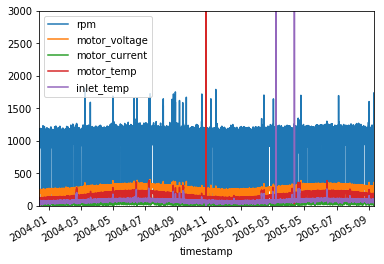

In [10]:
rms_clean.plot(ylim=(-10, 3000))

## Alarms

I want to overlay the times of warnings and errors:

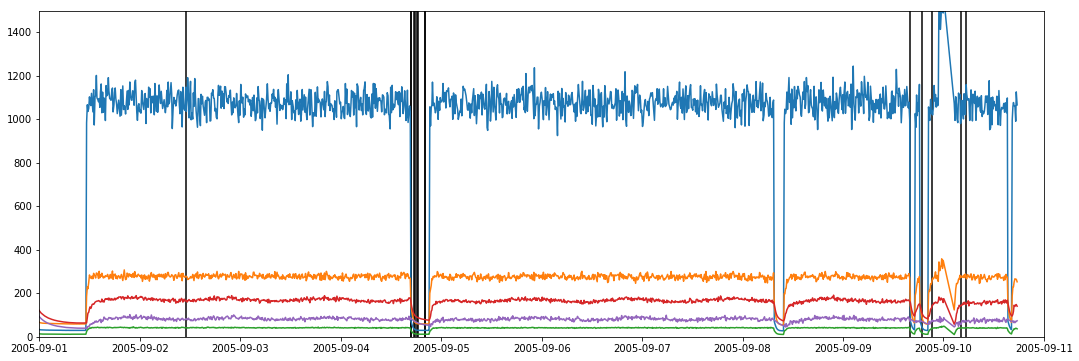

In [11]:
import numpy as np
import datetime as dt
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(18,6))
#plt.plot(rms_clean)
#fig.tight_layout()
axes.set_ylim(0,1500)
axes.set_xlim(pd.Timestamp("2005-09-01"),pd.Timestamp("2005-09-11"))
for d,m in zip(alarms.index,alarms["message"].values=="warning"):
    ls = "-"
    cl = "black"
    if not m: 
        ls = "--"
        cl = "grey"
    plt.plot([d,d],[0.,10000.], color=cl, ls=ls)
plt.plot(rms_clean)
plt.show()

In this snapshot, warning signals seem to be often, but not always, triggered by anomalous looking events in the sensor data. But, judging by eye, it seems very unclear to me what exactly might cause a warning and what now.

## All training data

Let's define a cleaning function and load al the data.

In [12]:
def clean(df):
    df.drop(df[(df[[col for col in df.columns]]<0).any(axis=1)].index, inplace=True)
    df.drop(df[(df[[col for col in df.columns]]>1e6).any(axis=1)].index, inplace=True)

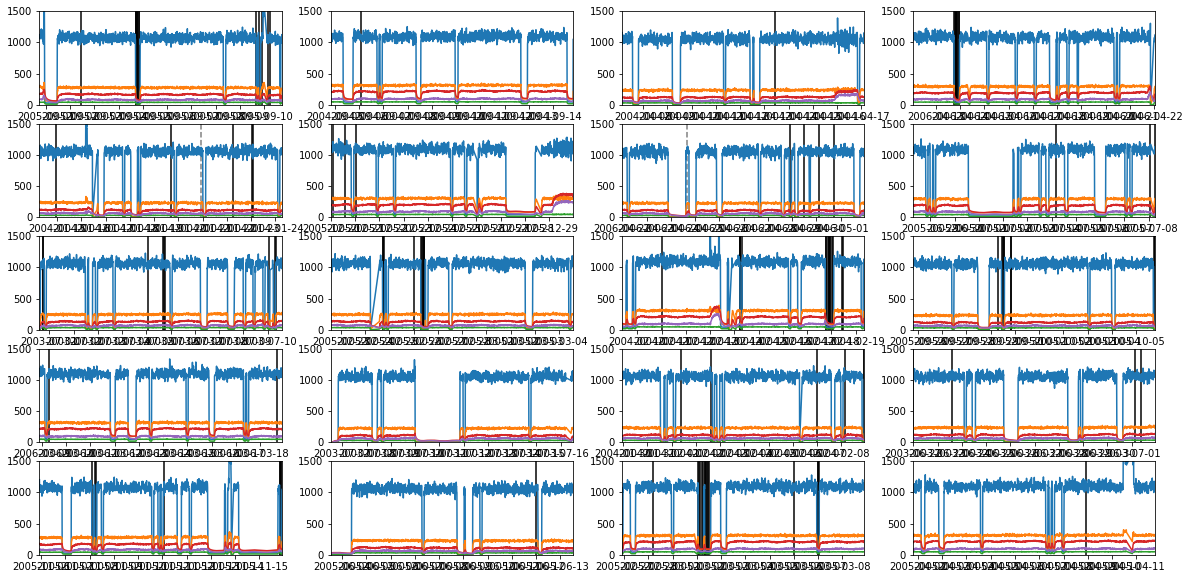

In [13]:
n_rows = 5
n_cols = 4
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20,10))
data = []
alarm = []
for i in np.arange(0,np.min([n_rows*n_cols,20])):
    data.append(load_rms('data/train/unit%04d_rms.csv'%(i)))
    alarm.append(load_alarms('data/train/unit%04d_alarms.csv'%(i)))
    clean(data[i])
    ax  = axes.flat
    ax[i].set_ylim(0,1500)
    maxT = data[i].index.max()
    ax[i].set_xlim(maxT-pd.Timedelta(days=10),maxT)
    for d,m in zip(alarm[i].index,alarm[i]["message"].values=="warning"):
        ls = "-"
        cl = "black"
        if not m: 
            ls = "--"
            cl = "grey"
        ax[i].plot([d,d],[0.,10000.], color=cl, ls=ls)
    ax[i].plot(data[i])
plt.show()    

In [14]:
lifetimes = []
warnings = []
errors = []
for i,s in enumerate(data):
    smin = s.index.min()
    smax = s.index.max()
    lifetimes.append((smax-smin).days)
    warnings.append((alarm[i]["message"]=="warning").sum())
    errors.append((alarm[i]["message"]=="error").sum())
    print("Sensor %2d: %s - %s : %4d days  (%3d warnings, %2d errors)"%(i,smin.date(),smax.date(), lifetimes[i], 
                                                                   warnings[i], errors[i]))
print("Average lifetime: %.1f days"%(np.mean(lifetimes)))

Sensor  0: 2003-12-13 - 2005-09-10 :  636 days  (304 warnings,  1 errors)
Sensor  1: 2004-03-15 - 2004-09-14 :  183 days  ( 65 warnings,  1 errors)
Sensor  2: 2004-03-01 - 2004-04-17 :   46 days  ( 24 warnings,  0 errors)
Sensor  3: 2003-12-12 - 2006-04-22 :  861 days  (444 warnings,  6 errors)
Sensor  4: 2003-02-24 - 2004-01-24 :  334 days  (144 warnings,  3 errors)
Sensor  5: 2004-07-29 - 2005-12-29 :  518 days  (199 warnings,  3 errors)
Sensor  6: 2003-04-17 - 2006-05-01 : 1110 days  (484 warnings, 12 errors)
Sensor  7: 2004-11-08 - 2005-07-08 :  241 days  ( 96 warnings,  1 errors)
Sensor  8: 2003-04-30 - 2003-07-10 :   70 days  ( 55 warnings,  2 errors)
Sensor  9: 2004-12-24 - 2005-03-04 :   69 days  ( 30 warnings,  1 errors)
Sensor 10: 2003-07-11 - 2004-02-19 :  223 days  ( 95 warnings,  1 errors)
Sensor 11: 2004-08-27 - 2005-10-05 :  403 days  (178 warnings,  1 errors)
Sensor 12: 2004-09-15 - 2006-03-18 :  549 days  (217 warnings,  5 errors)
Sensor 13: 2003-07-06 - 2003-07-16 :  

Looking at this, I see very little reason to believe that the alarm messages are likely to tell me much about the failures. Some units have no warnings, and the plots don't show any hint at increased likelihood of a warning message before failure.

**Based on these, admittedly vague, observations I decided to basically ignore the alarm messages for the purpose of finding  a predictor for failure.**

In [15]:
# data

Commented out here to reduce line output is a look at the data in general. It seems like measurements have no strictly defined frequency but were taken about every 10 minutes.

I thought about smoothing the data since the rpm part, in particular, seems to have some measurement noise. Given the roughly 10-minute intervals, I considered 1-hour-window rolling averages, removing 5/6 of the rows after this smooting.

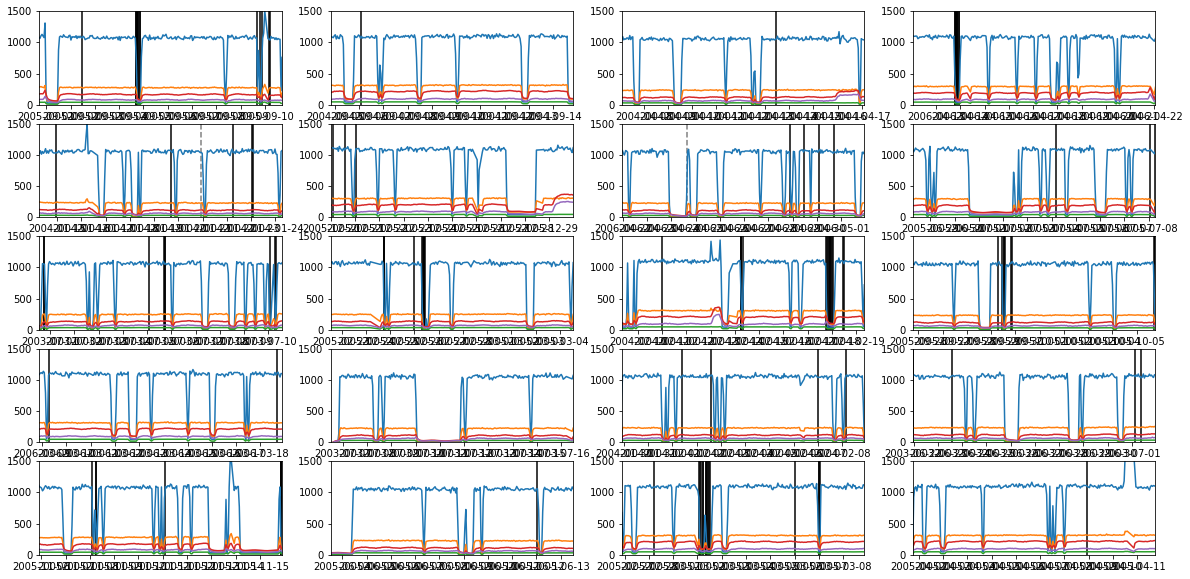

In [16]:
sensor = []
n_rows = 5
n_cols = 4
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20,10))
for i in np.arange(0,np.min([n_rows*n_cols,20])):
    sensor.append(data[i].rolling(pd.Timedelta(hours=1)).mean()) # rolling average
    sensor[i] = sensor[i].loc[sensor[i].index[::6]]    # removing 5 of 6 consecutive values, since most are ~10 min spaced.
    ax  = axes.flat
    ax[i].set_ylim(0,1500)
    maxT = sensor[i].index.max()
    ax[i].set_xlim(maxT-pd.Timedelta(days=10),maxT)
    for d,m in zip(alarm[i].index,alarm[i]["message"].values=="warning"):
        ls = "-"
        cl = "black"
        if not m: 
            ls = "--"
            cl = "grey"
        ax[i].plot([d,d],[0.,10000.], color=cl, ls=ls)
    ax[i].plot(sensor[i])
plt.show()    

I didn't have any immediate insights from looking at this. Since all the approaches I tried ran very quickly with the full data, I decided not to use the smoothed data except for one cross check later.

## PCA

The 5 different sensor values look strongly correlated, as would be expected for measurements pertaining to the same unit. I made a principal component analysis to see to what degree a 1-dimensional projection can capture the information.

In [17]:
from sklearn.decomposition import PCA
pca = PCA(n_components=1, whiten=True).fit(data[0])

In [18]:
print(pca.components_)

[[0.97340215 0.19678631 0.02909183 0.11157563 0.02163218]]


In [19]:
print(pca.explained_variance_ratio_)

[0.74788597]


For unit 0, there is some loss of information according to the fraction of the total variance in its 1-D projection.

In [20]:
for i in np.arange(1,20):
    pca = PCA(n_components=1, whiten=True).fit(data[i])
    print(pca.explained_variance_ratio_)

[0.98099235]
[0.99314656]
[0.97790415]
[0.99182846]
[0.58938748]
[0.85862254]
[0.97762957]
[0.99464283]
[0.99400875]
[0.97543961]
[0.89372593]
[0.97688469]
[0.99777876]
[0.99549253]
[0.99573275]
[0.80029506]
[0.9790937]
[0.84156315]
[0.98074841]


For most of the other units, the 1-D PCA has a very high explained variance ratio. So, maybe there are just a couple weird units, but with so little data available, it does not seem wise to us the 1-d representation. 

## Thoughts at this point

About attempting forecasting: In order to identify failure probability of the units it seems too complex to me to attempt a full time-series modeling that predicts future measurements. Rather, I want to look for a "signal" that shows up at some point before the failure. 
The plots above also don't immediately show some kind of slow trend in any of the measurements over long periods of time (i.e. several months). Hence, I did not worry about dismissing early measurements for the purpose of identifying a failure signal. 
With an average lifetime on the order of a year, but large variation in lifetime, I decided to focus on timescales up to a month, and to simplify the data via summary statistics.

## Summary stats only

With the expectation of a consistent feature appearing not too long before failure, I define a time window (`tw`) and list the data within this period before the end for each unit in a list called `failed`. I exclude units with lifetimes shorter than this time window. I also skip the last entry (`skipend`), just in case it os already affected by the ongoing failure at this point, which would be a false clue that doesn't pertain to still running units.
If the lifetime of a unit was at least 3 times `tw` and greater than 2 days, then I also take the first part of the data of length `tw` and list it in `running`, since I assume that no hint of failure is included at this early stage. There is a 1-day offset for the beginning of this data from the first csv entry, since I saw that some start with basically zero data that would not be realistic for an already runing unit.


In [21]:
skipend = 1
tw = 30 # in days
running = []
failed = []
timeindex = []
for l,s in zip(lifetimes, data): 
    if l<tw: 
        continue
    start = s.index[0]
    end = s.index[-1]-pd.Timedelta(days=tw)
    if (l >= np.max([3*tw, 2])):
        failed.append(s.loc[end:s.index[-skipend]])
        for n in np.arange(1,2): # at some point, I extracted 2 running periods here, but got worried about imbalanced training
            begin = start+n*pd.Timedelta(days=1)
            running.append(s.loc[begin:begin+pd.Timedelta(days=tw)])
    else:
        failed.append(s.loc[end:s.index[-skipend]])

I then greatly simplify the data by calculating only the min, max, average, and standard deviation for each stored time window.

In [22]:
def summarize(d):
    return np.array([[d[c].min(),d[c].max(),d[c].mean(),d[c].std()] for c in d.columns]).flatten()

In [23]:
sd_running = np.array([summarize(d) for d in running])
sd_failed = np.array([summarize(d) for d in failed])
print(len(sd_running))
print(len(sd_failed))

14
19


In [24]:
x = np.concatenate([sd_running, sd_failed])
y = np.concatenate([np.zeros(len(sd_running)), np.ones(len(sd_failed))])
print(len(x))
print(len(y))

33
33


I now have 19 samples labeled with 0 for `running` and 19 samples labeled with 1 for `failed`.

I create a train/test split with 1/3 reserved for test.

In [25]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y,test_size=0.333, random_state=3)

In [26]:
display(y_train)
display(y_test)

array([1., 1., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0.,
       0., 1., 0., 1., 1.])

array([0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0.])

# Random Forest

I tried a Random Forest ensemble classifier. Playing around with the number of estimators (trees) didn't change the outcome much, at least not if > ~10.

In [27]:
from sklearn.metrics import precision_score,recall_score
from sklearn.ensemble import RandomForestClassifier
modelRF = RandomForestClassifier(n_estimators=20)
modelRF.fit(x_train,y_train)
scoreRF = modelRF.score(x_test,y_test)
print("accuracy: %f,  "%scoreRF)
pred_test = modelRF.predict(x_test)
print("Precision: ", precision_score(y_test,pred_test))
print("Recall:    ", recall_score(y_test,pred_test))

accuracy: 0.818182,  
Precision:  1.0
Recall:     0.7142857142857143


### Result:
I get an ~80% accuracy, and have no false positives (precision = 1.0, positives being predictions of unit failure). This model can only identify about 2/3 of the samples that represent data just before unit failure (recall = ~0.7).
I played around with seeding the train/test split differently and got quite a bit variation, so this is not a very stable model. Obviously, my training data is quite limited.

Then I played with the time window. 

In [28]:
skipend = 1
tw = 10 # in days
running = []
failed = []
timeindex = []
for l,s in zip(lifetimes, data): 
    if l<tw: 
        continue
    start = s.index[0]
    end = s.index[-1]-pd.Timedelta(days=tw)
    if (l >= np.max([3*tw, 2])):
        failed.append(s.loc[end:s.index[-skipend]])
        for n in np.arange(1,2): # at some point, I extracted 2 running periods here, but got worried about imbalanced training
            begin = start+n*pd.Timedelta(days=1)
            running.append(s.loc[begin:begin+pd.Timedelta(days=tw)])
    else:
        failed.append(s.loc[end:s.index[-skipend]])
        
sd_running = np.array([summarize(d) for d in running])
sd_failed = np.array([summarize(d) for d in failed])
x = np.concatenate([sd_running, sd_failed])
y = np.concatenate([np.zeros(len(sd_running)), np.ones(len(sd_failed))])
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y,test_size=0.333, random_state=2)

In [29]:
modelRF.fit(x_train,y_train)
scoreRF = modelRF.score(x_test,y_test)
print("accuracy: %f,  "%scoreRF)
pred_test = modelRF.predict(x_test)
print("Precision: ", precision_score(y_test,pred_test))
print("Recall:    ", recall_score(y_test,pred_test))

accuracy: 0.923077,  
Precision:  0.875
Recall:     1.0


## Conclusions

I did not store all `tw` attempts here, but varying it between 30 and 0.05 days produced quite different precision/recall estimates for my model. Changing the random seed for the train/test split, or even simply rerunning the training, does also alter the results. For tw ~ 10 days, it seems I do get nearly always about 0.9 or better for all three model evaluators.
I tried to create at least more `running` samples by taking another tw period out of the still-running phase for each unit with data long enough. But I did not get significantly more stable training results.
Given the small training/test sample, I'm not very confident about tis model.
For this excercise, I decided not to try the many other possible models (SVM, etc.).
I did rerun the training with the smoothed data (hourly averaged) but did not see  more stable performance.

One more look by eye at `running` 10-day samples:

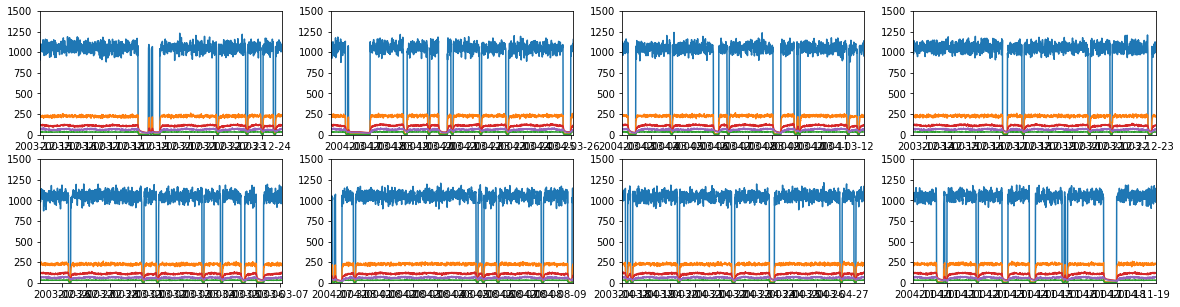

In [30]:
n_rows = 2
n_cols = 4
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20,5))
ax = axes.flat
for i in np.arange(0,(n_rows*n_cols)):
    ax[i].set_ylim(0,1500)
    maxT = running[i].index[-1]
    ax[i].set_xlim(maxT-pd.Timedelta(days=tw),maxT)
    ax[i].plot(running[i].loc[maxT-pd.Timedelta(days=tw):])
plt.show()

And the `failed` ones, i.e. 10 days before the end of each data set:

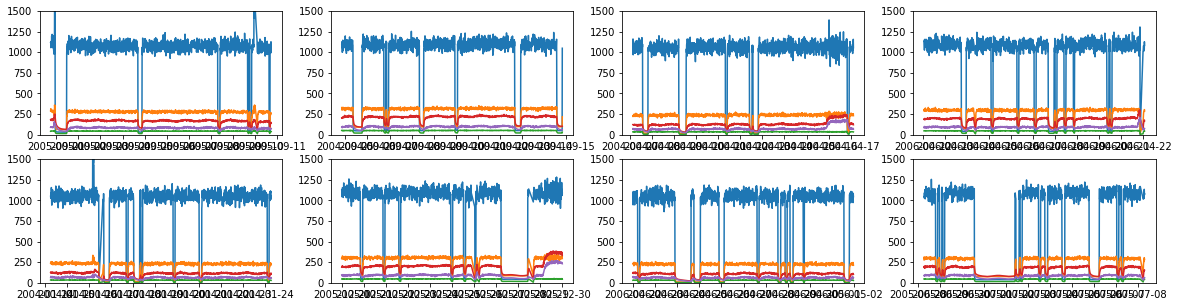

In [31]:
n_rows = 2
n_cols = 4
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20,5))
ax = axes.flat
for i in np.arange(0,(n_rows*n_cols)):
    ax[i].set_ylim(0,1500)
    maxT = failed[i].index[-1]
    ax[i].plot(failed[i].loc[maxT-pd.Timedelta(days=tw):])
plt.show()

There might be more fluctuations, and hence a larger standard deviation, in the `failed` samples, but I don't see anything that could clearly help to understand if my model is any good.

# The Test datasets

Load the test data and clean and shorten it as done with the training data above:

In [32]:
test_data = []
test_alarm = []
for i in np.arange(0,30):
    test_data.append(load_rms('data/test/unit%04d_rms.csv'%(i+20)))
    test_alarm.append(load_alarms('data/test/unit%04d_alarms.csv'%(i+20)))
    clean(test_data[i])

In [33]:
shortened_test_data = []
for s in test_data:
    end = s.index[-1]-pd.Timedelta(days=tw)
    shortened_test_data.append(s.loc[end:s.index[-1]])
testing = np.array([summarize(d) for d in shortened_test_data])

In [34]:
predictions = modelRF.predict(testing)
predictions

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [35]:
print("Predictions:")
for i in np.arange(0,30):
    if predictions[i]==1:
        print("Unit %04d: Yes"%(i+20))
    else:
        print("Unit %04d: No"%(i+20))
        

Predictions:
Unit 0020: Yes
Unit 0021: Yes
Unit 0022: Yes
Unit 0023: Yes
Unit 0024: Yes
Unit 0025: Yes
Unit 0026: Yes
Unit 0027: Yes
Unit 0028: Yes
Unit 0029: Yes
Unit 0030: Yes
Unit 0031: Yes
Unit 0032: Yes
Unit 0033: Yes
Unit 0034: Yes
Unit 0035: Yes
Unit 0036: Yes
Unit 0037: Yes
Unit 0038: Yes
Unit 0039: Yes
Unit 0040: Yes
Unit 0041: Yes
Unit 0042: Yes
Unit 0043: Yes
Unit 0044: Yes
Unit 0045: Yes
Unit 0046: Yes
Unit 0047: Yes
Unit 0048: Yes
Unit 0049: Yes


Surprisingly, my model predicts failure of al units. I find it unlikely that the challenge was set up this way, but my model seems to be picking p at something that is not present in my mock `running` samples above.
If it were correct, than that would predict failure for all these units within about 10 days, with only about 1--15 % false positives.

A look at some f the test data:

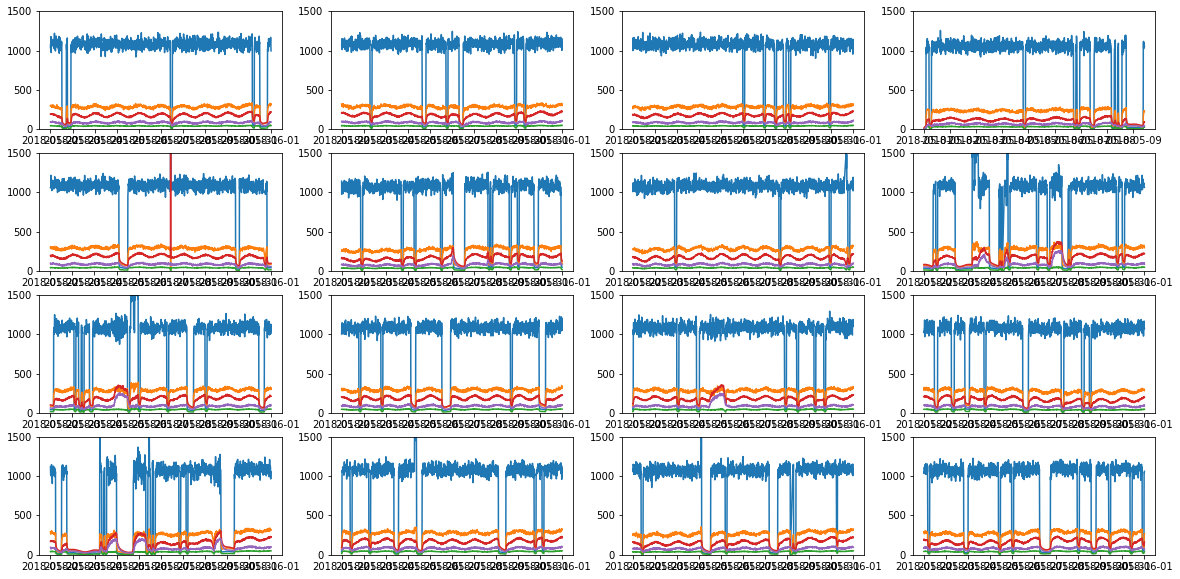

In [36]:
n_rows = 4
n_cols = 4
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20,10))
ax = axes.flat
for i in np.arange(0,(n_rows*n_cols)):
    ax[i].set_ylim(0,1500)
    maxT = shortened_test_data[i].index[-1]
    ax[i].plot(shortened_test_data[i].loc[maxT-pd.Timedelta(days=tw):])
plt.show()

Well, these data do seem to have significantly more variance in basically all the sensor measurements. So that might at least explain why my model predicts failure. I have to conclude with the observations that the differences between train and test data are quite pronounced. Thus, they invalidate certainly my summary statistics approach, but they also seem to make any modeling difficult.